### Вводим названия и маппинг имен показателей

In [45]:
import pandas as pd
import numpy as np
from typing import List, Tuple
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.base import RegressorMixin
import pickle

LEARN_DATA_FILE = 'learn_data.csv'
MODEL_GRADIENT_FILE = 'model_gradient.pkl'
MODEL_REGRESSION_FILE = 'model_linear.pkl'

FEATURE = ['requirements', 'tests_hardness']
Y = 'testing_hours'

name_mapping = {
    'requirements': 'Функциональных требований ',
    'tests_hardness': 'Сложность тестов (баллы)',
    'testing_hours': 'Часы тестирования',
    f'{Y}_pred': 'Предсказание',
}

def with_read_cols(data: pd.DataFrame):
    data = data.copy().rename(columns=name_mapping)

    return data

### Записываем данные о проведенных экспериментах в массив и далее в .csv тпблицу

In [46]:
data = [
    {'index': 1, 'requirements': 10, 'tests_hardness': 3, 'testing_hours': 30},
    {'index': 2, 'requirements': 20, 'tests_hardness': 4, 'testing_hours': 50},
    {'index': 3, 'requirements': 15, 'tests_hardness': 5, 'testing_hours': 60},
    {'index': 4, 'requirements': 25, 'tests_hardness': 2, 'testing_hours': 40},
    {'index': 5, 'requirements': 30, 'tests_hardness': 6, 'testing_hours': 70},
]

df = pd.DataFrame.from_records(data)
df.set_index('index')
df.to_csv(LEARN_DATA_FILE, index=False)
with_read_cols(df)

,index,Функциональных требований,Сложность тестов (баллы),Часы тестирования
0,1,10,3,30
1,2,20,4,50
2,3,15,5,60
3,4,25,2,40
4,5,30,6,70


### Далее загружаем введенные данные

In [47]:
learn_df = pd.read_csv(LEARN_DATA_FILE)
learn_df.set_index('index')
with_read_cols(learn_df)

,index,Функциональных требований,Сложность тестов (баллы),Часы тестирования
0,1,10,3,30
1,2,20,4,50
2,3,15,5,60
3,4,25,2,40
4,5,30,6,70


### Производим визуализацию зависимость часов тестирования от кол-ва функциональных требований и сложности тестов

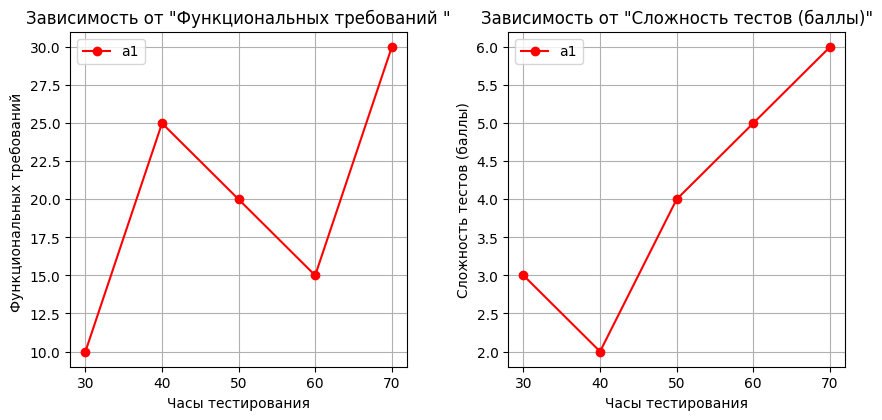

In [48]:
from matplotlib import pyplot as plt
from matplotlib.pyplot import subplots_adjust

def get_values_xy_for(feature: str) -> List[Tuple[int, int]]:
    result = []
    for _, row in learn_df.sort_values(Y, axis=0).iterrows():
        x = row[feature]
        y = row[Y]

        result.append((x, y))

    return result

fig = plt.figure(num=1, facecolor='w', edgecolor='k')
fig.set_figwidth(10)
fig.set_figheight(10)
subplots_adjust(hspace=0.3, wspace=0.3)


for index, feature in enumerate(FEATURE):
    data = get_values_xy_for(feature=feature)
    yy = list(map(lambda x: x[0], data))
    xx = list(map(lambda x: x[1], data))

    ax = fig.add_subplot(2, 2, index + 1)
    ax.plot(xx, yy, color='red', label=f'a1', linestyle='solid', marker='o')
    ax.set_title('Зависимость от ' + '"' + f'{name_mapping[feature]}' + '"')
    ax.set_ylabel(name_mapping[feature])
    ax.set_xlabel(name_mapping[Y])
    ax.grid()
    ax.legend()

plt.show()

### Проводим предсказание на заданной модели с использованием градиентного спуска

In [49]:
from sklearn.metrics import mean_squared_error

test_df = learn_df.copy()

X = learn_df[FEATURE]
y = learn_df[Y]

model = GradientBoostingRegressor(
    loss='squared_error',
    learning_rate=0.02,
    n_estimators=200,
    criterion='friedman_mse',
    max_depth=5,
    min_samples_split=5,
)

model.fit(X, y)

print(f"Model score: {model.score(X, y)}")

model_predict = model.predict(test_df[FEATURE])
print(f"Mean squared error: {mean_squared_error(test_df[Y], model_predict)}")

with open(MODEL_GRADIENT_FILE,'wb') as file:
    pickle.dump(model, file)

Model score: 0.9928687320552363
Mean squared error: 1.4262535889527392


### Проводим предсказание на заданной модели с использованием линейной регрессии

In [50]:
from sklearn.metrics import mean_squared_error

test_df = learn_df.copy()

X = learn_df[FEATURE]
y = learn_df[Y]

model = LinearRegression(
    copy_X=True,
    fit_intercept=True,
    n_jobs=-1,
    positive=False
)

model.fit(X, y)

print(f"Model score: {model.score(X, y)}")
print(f"Model coef: {model.coef_}")
print(f"Model base: {model.intercept_}")

model_predict = model.predict(test_df[FEATURE])
print(f"Mean square error: {mean_squared_error(test_df[Y], model_predict)}")

with open(MODEL_REGRESSION_FILE,'wb') as file:
    pickle.dump(model, file)

Model score: 0.9296703296703297
Model coef: [0.72527473 7.91208791]
Model base: 3.8461538461538183
Mean square error: 14.06593406593407


#### Проведем тестирование результатов предсказаний, полученных с помощью данной модели. 
#### Сравним результаты реальных и предсказанных моделью значений

,index,Функциональных требований,Сложность тестов (баллы),Часы тестирования,testing_hours_pred1,testing_hours_pred2
0,1,10,3,30,31.841471,34.835165
1,2,20,4,50,50.000094,50.000000
2,3,15,5,60,59.582173,54.285714
3,4,25,2,40,40.417767,37.802198
4,5,30,6,70,68.158495,73.076923


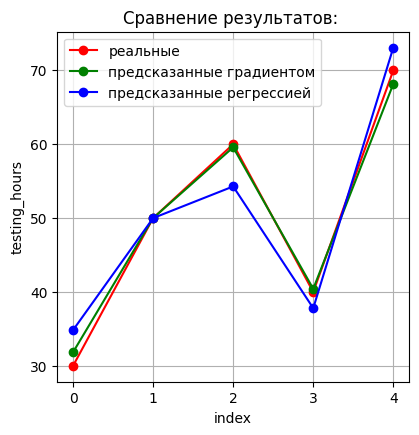

In [51]:
from matplotlib import pyplot as plt
from matplotlib.pyplot import subplots_adjust

Model1 = LinearRegression
Model2 = GradientBoostingRegressor

work_df = learn_df.copy()

with open(MODEL_GRADIENT_FILE, 'rb') as f:
    model1: Model1 = pickle.load(f)

with open(MODEL_REGRESSION_FILE, 'rb') as f:
    model2: Model2 = pickle.load(f)

predictions1 = model1.predict(work_df[FEATURE])
predictions2 = model2.predict(work_df[FEATURE])

show_df = work_df.copy()
show_df[f"{Y}_pred1"] = predictions1
show_df[f"{Y}_pred2"] = predictions2

fig = plt.figure(num=1, facecolor='w', edgecolor='k')
fig.set_figwidth(10)
fig.set_figheight(10)

x = list(show_df.index)
y1 = show_df[Y]
y2 = show_df[f"{Y}_pred1"]
y3 = show_df[f"{Y}_pred2"]

ax = fig.add_subplot(2, 2, 1)
ax.plot(x, y1, color='red', label=f'реальные', marker='o', linestyle='-')
ax.plot(x, y2, color='green', label=f'предсказанные градиентом', marker='o', linestyle='-')
ax.plot(x, y3, color='blue', label=f'предсказанные регрессией', marker='o', linestyle='-')

ax.set_title(f'Сравнение результатов: ')
ax.set_xlabel('index')
ax.set_ylabel(f'{Y}')
ax.grid()
ax.legend()
with_read_cols(show_df)
